In [138]:
#%matplotlib inline
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
import scipy.stats as stt
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

In [139]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

In [140]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

In [141]:
def load_data(selected_session,by_dir=False):
    
    """ Function to load data structured according to the format
        that the data were delivered to the retreat for
    """
    all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
    all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
    root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
    spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


    #This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
    spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

    #This is basically a big table (you can open it in excel) which contains
    #relevant information about each time the animal poked one of the ports
    task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

    #
    response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
    #alternatively to change the time window


    #not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
    single_units = np.load(os.path.join(root_dir,'single_units.npy'))
    
    
    seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
    seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))
    
    
    graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    graph_type1 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
    
    if by_dir:
        firing_rate_maps = get_task_responses_by_direction(task_event_df,response_table)
    else:
        firing_rate_maps = get_task_responses(task_event_df,response_table)
    
    return firing_rate_maps, task_event_df,seq0,seq1,graph_type0,graph_type1

In [142]:
def get_task_responses_by_direction(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                                (task_event_df['correct']==True) &  #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction)
                                               ].index           
                #print(len(table_index))
                #get the average
                firing_rate_maps[:,int(port),int(task),dix] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

In [143]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            #for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
            table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                            (task_event_df['correct']==True) &  #the poke was to the correct port
                                            (task_event_df['port']==port)        #the port poked was port
                                            #(task_event_df['direction']==direction)
                                           ].index           
            #print(len(table_index))
            #get the average
            firing_rate_maps[:,int(port),int(task)] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps

In [144]:

firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(0)
#spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
mds_frm = firing_rate_maps.swapaxes(0,2) #- spatial_map[:,:,None,None]
#valid_ix = np.where(~np.isnan(np.sum(firing_rate_maps,axis=(0,2,3))))[0]
#frm = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])

In [145]:
np.corrcoef(mds_frm[0][0],mds_frm[0][2])

array([[1.        , 0.97289025],
       [0.97289025, 1.        ]])

In [146]:
a = zscore(mds_frm[1])
a[np.isnan(a)] = 0

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Text(0, 0.5, 'Port #')

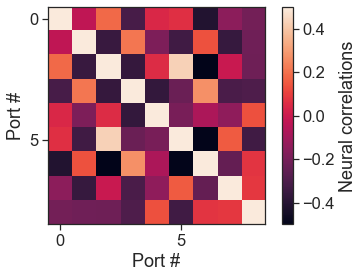

In [207]:
plt.imshow(np.corrcoef(a),vmin=-.5,vmax=.5)
cbar = plt.colorbar()
plt.locator_params(nbins=2)
cbar.set_label("Neural correlations")
plt.xlabel("Port #")
plt.ylabel("Port #")




In [148]:
zscore(np.mean(mds_frm,axis=1))[1].mean()

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


nan

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


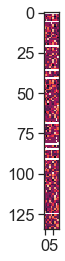

In [149]:
plt.imshow(zscore(mds_frm[0]).T)

In [150]:
#mean_state_resps = np.nanmean(mds_frm,axis=3).swapaxes(0,2)

In [180]:
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix

def zscore2(dat): return (dat-np.mean(dat,axis=0)[None,:])/np.nanstd(dat,axis=0,)[None,:]
def zscore(dat): return (dat-np.mean(dat))/np.nanstd(dat)

In [152]:
seq0_2 = np.array([list(seq0).index(i) for i in range(9)])
seq1_2 = np.array([list(seq1).index(i) for i in range(9)])

In [153]:
seq0

array([8, 4, 2, 5, 7, 0, 6, 1, 3])

In [154]:
#seq1

In [156]:
def loop_distance_matrix(seq,p=2):
    seq = list(seq)
    d = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
            ind1 = seq.index(i)
            ind2 = seq.index(j)
            d[i,j] = min([abs(ind1-ind2),abs(9+(ind1-ind2)),abs(9+(ind2-ind1))])**p
    return d

In [157]:
def line_distance_matrix(seq,p=1):
    seq = list(seq)
    d = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
            ind1 = seq.index(i)
            ind2 = seq.index(j)
            d[i,j] = abs(ind1-ind2)**p
    return d

In [158]:
#task_1_distance = loop_distance_matrix(seq0,p=2)
#task_2_distance = loop_distance_matrix(seq1,p=2)

In [159]:
if graph_type0=='loop': 
    task_1_distance = -loop_distance_matrix(seq0)
else: 
    task_1_distance =  -line_distance_matrix(seq0)#-(distance_matrix(seq0.reshape(-1,1),seq0.reshape(-1,1),p=1))
if graph_type1=='loop':
    task_2_distance = -loop_distance_matrix(seq1)
else:
    task_2_distance = -line_distance_matrix(seq1)#distance_matrix(seq1.reshape(-1,1),seq1.reshape(-1,1),p=1)
            
#task_1_distance = -(distance_matrix(seq0_2.reshape(-1,1),seq0_2.reshape(-1,1),p=1)%mod0)
#task_2_distance = -distance_matrix(seq1.reshape(-1,1)%mod1,seq1.reshape(-1,1)%mod1,p=2)
spatial_distance = -distance_matrix(poke_pos,poke_pos,p=1)

Text(0, 0.5, 'Port #')

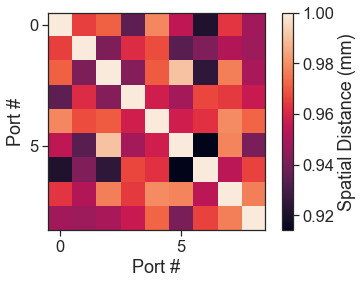

In [160]:
plt.imshow(np.corrcoef(mds_frm[1]))
cbar = plt.colorbar()
plt.locator_params(nbins=2)
cbar.set_label("Spatial Distance (mm)")
plt.xlabel("Port #")
plt.ylabel("Port #")



Text(0, 0.5, 'Port #')

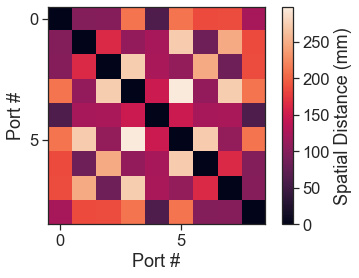

In [161]:
plt.imshow(-spatial_distance)

cbar = plt.colorbar()
plt.locator_params(nbins=2)
cbar.set_label("Spatial Distance (mm)")
plt.xlabel("Port #")
plt.ylabel("Port #")



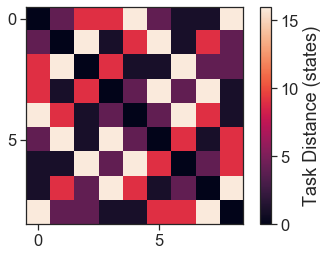

In [162]:
plt.imshow(-task_1_distance)

cbar = plt.colorbar()
plt.locator_params(nbins=2)
cbar.set_label("Task Distance (states)")



In [163]:
import statsmodels.api as sm

In [164]:
task1_corrs = np.corrcoef(mean_state_resps[0])
task2_corrs = np.corrcoef(mean_state_resps[1])

NameError: name 'mean_state_resps' is not defined

In [165]:
beta = np.linalg.inv(X.T@X)@X.T@y

NameError: name 'X' is not defined

In [166]:
plt.imshow((X@beta).reshape(8,9))
plt.colorbar()

NameError: name 'X' is not defined

In [167]:
np.corrcoef(y,(X@beta))

NameError: name 'y' is not defined

In [168]:
plt.imshow(y.reshape(8,9))
plt.colorbar()

NameError: name 'y' is not defined

In [169]:
def remove_diagonal(A):
    removed = A[~np.eye(A.shape[0], dtype=bool)].reshape(A.shape[0], int(A.shape[0])-1, -1)
    return np.squeeze(removed)


In [170]:
X = np.vstack([np.ones_like(remove_diagonal(spatial_distance).flatten()),
               zscore(remove_diagonal(spatial_distance).flatten()),
               zscore(remove_diagonal(task_1_distance).flatten()),
               zscore(remove_diagonal(task_2_distance).flatten())
              ]).T
y = remove_diagonal(task1_corrs).flatten()
res = sm.OLS(y,X,hasconst=True).fit()

IndexError: invalid index to scalar variable.

In [171]:
plt.imshow(task1_corrs)

NameError: name 'task1_corrs' is not defined

In [172]:
res.summary()

NameError: name 'res' is not defined

In [173]:

y = remove_diagonal(task2_corrs).flatten()
res2 = sm.OLS(y,X,hasconst=True).fit()

NameError: name 'task2_corrs' is not defined

In [174]:
res2.summary()

NameError: name 'res2' is not defined

In [175]:
res.params

NameError: name 'res' is not defined

In [176]:
mean_state_resps

NameError: name 'mean_state_resps' is not defined

(0, 1)

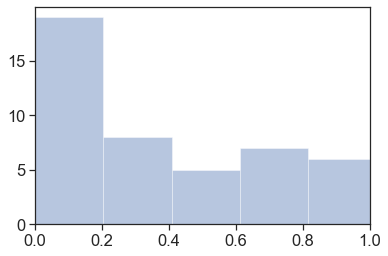

In [177]:
seaborn.distplot(firing_rate_maps.max(axis=(1,2)),kde=0,bins=np.linspace(0,10,num=50))
plt.xlim(0,1)

In [178]:
firing_rate_maps.shape

(135, 9, 2)

In [186]:
all_beta = []
all_pvals = []
for sess_ix in range(9):
    tmp  = []
    tmp_pvals = []
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix)
    mxs = firing_rate_maps.max(axis=(1,2))
    firing_rate_maps = firing_rate_maps - np.mean(firing_rate_maps,axis=2)[:,:,None]
    firing_rate_maps = firing_rate_maps[mxs>.5]
    mean_state_resps = firing_rate_maps.swapaxes(0,2)
    mean_state_resps = (mean_state_resps - np.mean(mean_state_resps,axis=(0,1))[None,None,:])/np.std(mean_state_resps,axis=(0,1))[None,None,:]
    mean_state_resps = np.nan_to_num(mean_state_resps)
    #mean_state_resps = np.nanmean(mds_frm,axis=3).swapaxes(0,2)
    if graph_type0=='loop': 
        task_1_distance = -loop_distance_matrix(seq0)
    else: 
        task_1_distance =  -line_distance_matrix(seq0)
    if graph_type1=='loop':
        task_2_distance = -loop_distance_matrix(seq1)
    else:
        task_2_distance = -line_distance_matrix(seq1)

    spatial_distance = -distance_matrix(poke_pos,poke_pos,p=1)
    
    msr0 = ((mean_state_resps[0] - np.mean(mean_state_resps[0],axis=0))/np.std(mean_state_resps[0],axis=0))
    msr1 = ((mean_state_resps[1] - np.mean(mean_state_resps[1],axis=0))/np.std(mean_state_resps[1],axis=0))
    task1_corrs = np.corrcoef(zscore2(msr0))
    task2_corrs = np.corrcoef(zscore2(msr1))
    
    
    #
    X = np.vstack([np.ones_like(remove_diagonal(spatial_distance).flatten()),
               zscore(remove_diagonal(spatial_distance).flatten()),
               zscore(remove_diagonal(task_1_distance).flatten()),
               zscore(remove_diagonal(task_2_distance).flatten())
              ]).T
    y = remove_diagonal(task1_corrs).flatten()
    beta = np.linalg.inv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    
    tmp.append(beta.copy())
    tmp_pvals.append(res.pvalues)
    
    y = remove_diagonal(task2_corrs).flatten()
    beta = np.linalg.inv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    tmp_pvals.append(res.pvalues)
    tmp.append(beta.copy())
    
    all_beta.append(tmp)
    all_pvals.append(tmp_pvals)
    #assert np.allclose(beta,res.params)

IndexError: list index out of range

In [187]:
np.corrcoef(msr0)

array([[ 1.00000000e+00, -2.03072682e-01, -2.61567095e-01,
        -4.61459395e-02, -1.43979643e-01, -1.26106529e-01,
        -1.60365223e-01, -2.16540840e-01,  4.13453931e-03],
       [-2.03072682e-01,  1.00000000e+00, -2.28529147e-01,
         6.24784734e-02, -4.98076804e-02, -1.43389507e-01,
         1.29150118e-01, -2.54946354e-01, -1.70235419e-01],
       [-2.61567095e-01, -2.28529147e-01,  1.00000000e+00,
        -1.65186783e-01, -6.46816604e-02, -6.00791070e-02,
        -2.34515318e-01, -2.27666800e-03, -4.65553835e-02],
       [-4.61459395e-02,  6.24784734e-02, -1.65186783e-01,
         1.00000000e+00, -6.61725411e-02, -2.62254841e-01,
         2.36962957e-04, -2.22247535e-01, -1.01900361e-01],
       [-1.43979643e-01, -4.98076804e-02, -6.46816604e-02,
        -6.61725411e-02,  1.00000000e+00, -1.60828174e-01,
        -8.59938312e-02, -1.27370591e-01, -2.78537922e-01],
       [-1.26106529e-01, -1.43389507e-01, -6.00791070e-02,
        -2.62254841e-01, -1.60828174e-01,  1.000000

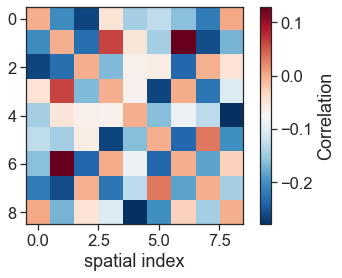

In [188]:
dta = task2_corrs.copy()
dta[np.diag_indices_from(dta)] = 0
plt.imshow(dta,cmap='RdBu_r')
plt.xlabel("spatial index")
plt.xlabel("spatial index")

cbar = plt.colorbar()
cbar.set_label("Correlation")

In [198]:
np.array(all_pvals).shape

(8, 2, 4)

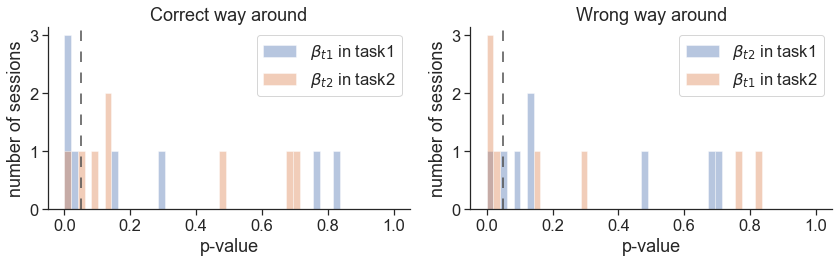

In [200]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Correct way around")
seaborn.distplot(np.array(all_pvals)[:,0,-2],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t1}$ in task1')
seaborn.distplot(np.array(all_pvals)[:,0,-1],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t2}$ in task2')
plt.axvline(x=0.05,dashes=(7,7),color='.3')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()

plt.subplot(1,2,2)
plt.title("Wrong way around")
seaborn.distplot(np.array(all_pvals)[:,1,-1],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t2}$ in task1')
seaborn.distplot(np.array(all_pvals)[:,1,-2],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t1}$ in task2')
plt.axvline(x=0.05,dashes=(7,7),color='.3')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()
plt.tight_layout()

In [191]:
np.array(all_pvals)[:,:,-2:].shape

(8, 2, 2)

In [192]:
res.pvalues

array([1.49772745e-17, 4.00861318e-05, 7.61518461e-01, 4.81748078e-01])

In [193]:
#n_sessions x n_tasks x n_params
all_beta = np.array(all_beta)

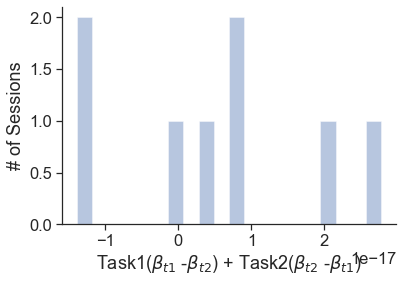

In [194]:
#n_sessions x n_tasks x n_params
all_beta = np.array(all_beta)

t1_m_t2_inT1 = (all_beta[:,0,-2] - all_beta[:,0,-1])
t1_m_t2_inT2 = (all_beta[:,1,-1] - all_beta[:,1,-2])

seaborn.distplot(t1_m_t2_inT1 + t1_m_t2_inT2,kde=0,bins=20)
plt.xlabel(r"Task1($\beta_{t1}$ -$\beta_{t2}$) + Task2($\beta_{t2}$ -$\beta_{t1}$)")
plt.ylabel("# of Sessions")
seaborn.despine()

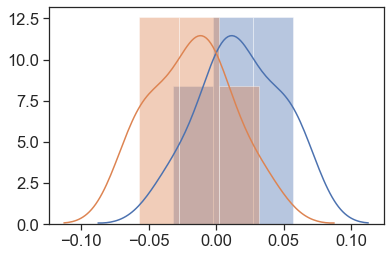

In [48]:
seaborn.distplot(t1_m_t2_inT1)
seaborn.distplot(t1_m_t2_inT2)

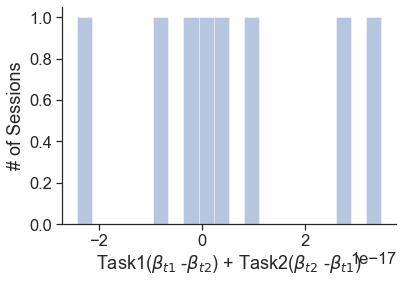

In [49]:
seaborn.distplot(t1_m_t2_inT1 + t1_m_t2_inT2,kde=0,bins=20)
plt.xlabel(r"Task1($\beta_{t1}$ -$\beta_{t2}$) + Task2($\beta_{t2}$ -$\beta_{t1}$)")
plt.ylabel("# of Sessions")
seaborn.despine()

In [50]:
stt.ttest_1samp(t1_m_t2_inT1 + t1_m_t2_inT2,popmean=0)

Ttest_1sampResult(statistic=0.7445967465797968, pvalue=0.4807604377694731)

# RSA Task distance with direction

In [51]:
sp

NameError: name 'sp' is not defined

In [52]:

#firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(0,by_dir=True)
spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
mds_frm = firing_rate_maps - spatial_map[:,:,None,None]
#valid_ix = np.where(~np.isnan(np.sum(firing_rate_maps,axis=(0,2,3))))[0]
#firing_rate_maps[:,int(port),int(task),dix]
frm = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])

AxisError: axis 3 is out of bounds for array of dimension 3

In [53]:
frm = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])
frm_t1 = frm[:,:18]
frm_t2 = frm[:,18:]

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [54]:
#this constructs the appropriate things if everything is ordered correctly according to states

T = np.zeros([18,18])
for i in range(9):
    T[i,(i+1)%9] = .95
    T[i,9+(i-1)%9] =0.05
    
for i in range(9,18):
    T[i,(i+1)%9] = .05
    T[i,9+(i-1)%9] =0.95

In [55]:
# def get_C_line_task(seq0,p=0.95):
#     """ Finish this requires updating the edges of the line"""
#     T1 = np.zeros([18,18])
#     for i in range(9):
#         T1[seq0[i],seq0[(i+1)%9]] = p
#         T1[seq0[i],9+seq0[(i-1)%9]] = 1-p

#     for i in range(9,18):
#         T1[seq0[i%9]+9,seq0[(i+1)%9]] = 1-p
#         T1[seq0[i%9]+9,9+seq0[(i-1)%9]] = p

        
# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#     T1[0] = 0; T1[0,1] = 1  #going to the right in state 0 will go to 1
#     T1[8] = 0; T1[8,-1] = 1   #going to the right in state 9 will go to state 8
#     T1[9] = 0; T1[9,1] = 1    #going to the left in state 0 will go to state 1
#     T1[-1] = 0; T1[-1,-1] = 1       #going to the left in state 
    
#     task_1_distance = -np.log(expm(T1))
#     return T1, task_1_distance

In [56]:
def get_C_loop_task(seq0,p=0.95):
    """p is the probability of continueing in the same direction"""
    #this constructs the appropriate things if everything is ordered correctly according to states

    T1 = np.zeros([18,18])
    for i in range(9):
        T1[seq0[i],seq0[(i+1)%9]] = p
        T1[seq0[i],9+seq0[(i-1)%9]] = 1-p

    for i in range(9,18):
        T1[seq0[i%9]+9,seq0[(i+1)%9]] = 1-p
        T1[seq0[i%9]+9,9+seq0[(i-1)%9]] = p

    task_1_distance = -np.log(expm(T1))
    #task_1_distance = np.linalg.pinv(np.eye(len(T1)) - 0.1  * T1)
    return T1, task_1_distance

In [57]:
def get_C_line_task(seq0,p=0.95):
    """ Finish this requires updating the edges of the line"""
    T1 = np.zeros([18,18])
    for i in range(9):
        T1[seq0[i],seq0[(i+1)%9]] = p
        T1[seq0[i],9+seq0[(i-1)%9]] = 1-p

    for i in range(9,18):
        T1[seq0[i%9]+9,seq0[(i+1)%9]] = 1-p
        T1[seq0[i%9]+9,9+seq0[(i-1)%9]] = p

        

    T1[seq0[0]] = 0; T1[seq0[0],seq0[1]] = 1  #going to the right in state 0 will go to 1
    T1[seq0[8]] = 0; T1[seq0[8],seq0[-1]+9] = 1   #going to the right in state 9 will go to state 8
    T1[seq0[9%9]+9] = 0; T1[seq0[9%9]+9,seq0[0]] = 1    #going to the left in state 0 will go to state 1
    T1[seq0[-1]+9] = 0; T1[seq0[-1]+9,seq0[-2]+9] = 1       #going to the left in state 
    
    task_1_distance = -np.log(expm(T1))
    #evals,evecs = np.linalg.eig(T1)
    #mx = np.max(np.abs(evals))
    #task_1_distance = (evecs@(evals_mtx**50)@np.linalg.inv(evecs)).real
    #task_1_distance = np.linalg.pinv(np.eye(len(T1)) - 0.1  * T1)
    return T1, task_1_distance

In [58]:
seq0

array([0, 2, 4, 3, 6, 8, 7, 1, 5])

In [59]:
T1[0]

NameError: name 'T1' is not defined

In [60]:
T1,C1 = get_C_line_task(np.arange(9))
plt.imshow(np.linalg.inv(np.eye(len(T1))- .4*T1))
plt.grid()
plt.colorbar()

NameError: name 'expm' is not defined

In [61]:
plt.imshow(-C1)

NameError: name 'C1' is not defined

In [62]:
T1[0]

NameError: name 'T1' is not defined

In [63]:
T1,C1 = get_C_line_task(seq0)

NameError: name 'expm' is not defined

In [64]:
evals,evecs = np.linalg.eig(T1)
oo = (evecs@(evals_mtx**50)@np.linalg.inv(evecs)).real

NameError: name 'T1' is not defined

In [65]:
plt.imshow(T1)

NameError: name 'T1' is not defined

In [66]:
plt.imshow(np.linalg.pinv(np.eye(len(T1)) - -.7  * T1))

NameError: name 'T1' is not defined

In [67]:
plt.plot(C1[0])

NameError: name 'C1' is not defined

In [68]:
ix = 9
print(T1[ix][:9])
print(T1[ix][9:])

NameError: name 'T1' is not defined

In [69]:
#this constructs the appropriate things if everything is ordered correctly according to states

T1 = np.zeros([18,18])
for i in range(9):
    T1[seq0[i],seq0[(i+1)%9]] = .95
    T1[seq0[i],9+seq0[(i-1)%9]] =0.05
    
for i in range(9,18):
    T1[seq0[i%9]+9,seq0[(i+1)%9]] = .05
    T1[seq0[i%9]+9,9+seq0[(i-1)%9]] =0.95

In [70]:
#this constructs the appropriate things if everything is ordered correctly according to states

T2 = np.zeros([18,18])
for i in range(9):
    T2[seq1[i],seq1[(i+1)%9]] = .95
    T2[seq1[i],9+seq1[(i-1)%9]] =0.05
    
for i in range(9,18):
    T2[seq1[i%9]+9,seq1[(i+1)%9]] = .05
    T2[seq1[i%9]+9,9+seq1[(i-1)%9]] =0.95

In [71]:
task_1_distance = -np.log(expm(T1))
task_2_distance = -np.log(expm(T2))

NameError: name 'expm' is not defined

In [72]:
evals, evecs = np.linalg.eig(T.T)
evals_mtx = np.eye(len(evals))*evals
evec1 = evecs[:,np.isclose(evals, 1)]

#Since np.isclose will return an array, we've indexed with an array
#so we still have our 2nd axis.  Get rid of it, since it's only size 1.
evec1 = evec1[:,0]

stationary = evec1 / evec1.sum()

#eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
stationary = stationary.real


In [73]:
from scipy.linalg import expm

In [74]:
C2 = -np.log(evecs@expm(evals_mtx)@np.linalg.inv(evecs))

In [75]:
spatial_distance =  spatial_distance = -distance_matrix(np.vstack([poke_pos,poke_pos]),
                                                        np.vstack([poke_pos,poke_pos]),p=1)

In [76]:
task1_corrs = np.corrcoef(frm_t1.T)
task2_corrs = np.corrcoef(frm_t2.T) 

select_indices = (np.eye(len(task1_corrs)) + np.isnan(task1_corrs) + np.isnan(task2_corrs))==0

NameError: name 'frm_t1' is not defined

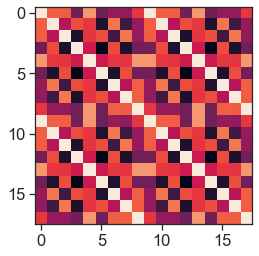

In [77]:
plt.imshow(spatial_distance)

In [78]:
y = zscore(task2_corrs[select_indices].flatten())
X = np.vstack([np.ones_like(y),
           zscore(spatial_distance[select_indices].flatten()),
           zscore(task_1_distance[select_indices].flatten()),
           zscore(task_2_distance[select_indices].flatten())
          ]).T
beta = np.linalg.inv(X.T@X)@X.T@y
res = sm.OLS(y,X,hasconst=True).fit()


NameError: name 'select_indices' is not defined

In [79]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     6.603
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           0.000556
Time:                        17:43:17   Log-Likelihood:                 72.213
No. Observations:                  72   AIC:                            -136.4
Df Residuals:                      68   BIC:                            -127.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1234      0.011    -11.469      0.000      -0.145      -0.102
x1             0.0490      0.011      4.393      0.000       0.027       0.071
x2             0.0034      0.011      0.305      0.762      -0.019       0.026
x3            -0.0081      0.012     -0.707      0.482      -0.031       0.015
==============================================================================
Omnibus:                        1.502   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.472   Jarque-Bera (JB):                0.981
Skew:                          -0.269   Prob(JB):                        0.612
Kurtosis:                       3.193   Cond. No.                         1.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# batch over all tasks

In [80]:
all_beta = []
all_pvals = []
for sess_ix in range(8):
    tmp  = []
    tmp_pvals = []
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix,by_dir=True)
    mxs = np.nanmax(firing_rate_maps,axis=(1,2,3))
    firing_rate_maps = firing_rate_maps[mxs>5]
    #spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
    mds_frm = firing_rate_maps #- spatial_map[:,:,None,None]

   
    
    frm = np.hstack([mds_frm[:,:,0,0],mds_frm[:,:,0,1],mds_frm[:,:,1,0],mds_frm[:,:,1,1]])
    frm_t1 = frm[:,:18].T
    frm_t2 = frm[:,18:].T

    if graph_type0=='loop': 
        task_1_distance = get_C_loop_task(seq0)[1]
    else: 
        task_1_distance =  get_C_line_task(seq0)[1]
    if graph_type1=='loop':
        task_2_distance = get_C_loop_task(seq1)[1]
    else:
        task_2_distance = get_C_line_task(seq1)[1]

    task_1_distance = np.nan_to_num(task_1_distance,np.nanmean(task_1_distance))
    task_2_distance = np.nan_to_num(task_2_distance,np.nanmean(task_2_distance))
    #spatial_distance = -distance_matrix(poke_pos,poke_pos,p=1)
    spatial_distance =   -distance_matrix(np.vstack([poke_pos,poke_pos]),
                                          np.vstack([poke_pos,poke_pos]),p=1)
    
    task1_corrs = np.corrcoef(frm_t1)
    task2_corrs = np.corrcoef(frm_t2)
    select_indices = (np.eye(len(task1_corrs)) + 
                      np.isnan(task1_corrs) + 
                      np.isnan(task2_corrs) + 
                      np.isnan(task_1_distance) + 
                      np.isnan(task_2_distance) + 
                      np.isnan(spatial_distance)
                     )==0
    
    #
    y = task1_corrs[select_indices].flatten()
    X = np.vstack([np.ones_like(y),
               zscore(spatial_distance[select_indices].flatten()),
               zscore(task_1_distance[select_indices].flatten()),
               zscore(task_2_distance[select_indices].flatten())
              ]).T
    
    #y = remove_diagonal(task1_corrs).flatten()
    #beta = np.linalg.pinv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    
    tmp.append(res.params)
    tmp_pvals.append(res.pvalues)
    
    y = task2_corrs[select_indices].flatten()
    #beta = np.linalg.pinv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    tmp_pvals.append(res.pvalues)
    tmp.append(res.params)
    
    all_beta.append(tmp)
    all_pvals.append(tmp_pvals)
    #assert np.allclose(beta,res.params)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher

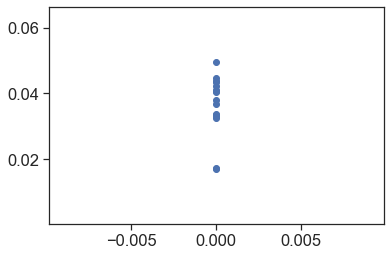

In [91]:
plt.scatter([0]*16,np.array(all_beta)[:,:,1].flatten())

In [90]:
np.array(all_pvals)[:,:,1].flatten().shape

(16,)

No handles with labels found to put in legend.


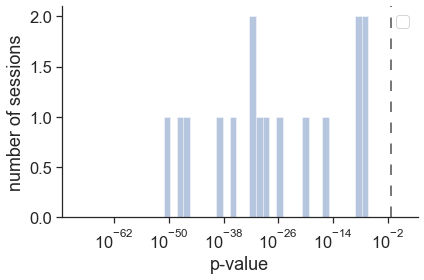

In [81]:
seaborn.distplot(np.array(all_pvals)[:,:,1].flatten(),kde=0,bins=np.logspace(-70,1,num=50),)
plt.axvline(x=0.05,dashes=(7,7),color='.3')
#plt.xticks([1])
#plt.xlim(0,1)
plt.xscale('log')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()
plt.tight_layout()

In [2378]:
np.array(all_pvals)[:,:,2]

array([[0.59940686, 0.80197233],
       [0.06274084, 0.73383098],
       [0.01556136, 0.97484913],
       [0.00439714, 0.00595021],
       [0.6112544 , 0.77027963],
       [0.66940644, 0.48330991],
       [0.38250453, 0.38908654],
       [0.64233191, 0.60688962]])

In [2379]:
np.logspace(-2,0,num=50)

array([0.01      , 0.01098541, 0.01206793, 0.01325711, 0.01456348,
       0.01599859, 0.01757511, 0.01930698, 0.02120951, 0.02329952,
       0.02559548, 0.02811769, 0.03088844, 0.03393222, 0.03727594,
       0.04094915, 0.04498433, 0.04941713, 0.05428675, 0.05963623,
       0.06551286, 0.07196857, 0.07906043, 0.08685114, 0.09540955,
       0.10481131, 0.11513954, 0.12648552, 0.13894955, 0.1526418 ,
       0.16768329, 0.184207  , 0.20235896, 0.22229965, 0.24420531,
       0.26826958, 0.29470517, 0.32374575, 0.35564803, 0.39069399,
       0.42919343, 0.47148664, 0.51794747, 0.5689866 , 0.62505519,
       0.68664885, 0.75431201, 0.82864277, 0.91029818, 1.        ])

In [2380]:
#plt.imshow(select_indices)

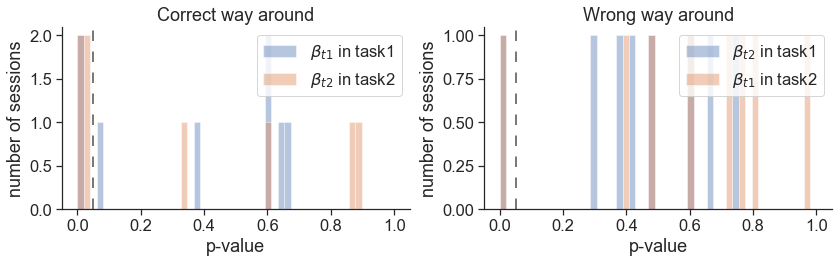

In [2381]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Correct way around")
seaborn.distplot(np.array(all_pvals)[:,0,-2],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t1}$ in task1')
seaborn.distplot(np.array(all_pvals)[:,1,-1],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t2}$ in task2')
plt.axvline(x=0.05,dashes=(7,7),color='.3')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()

plt.subplot(1,2,2)
plt.title("Wrong way around")
seaborn.distplot(np.array(all_pvals)[:,0,-1],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t2}$ in task1')
seaborn.distplot(np.array(all_pvals)[:,1,-2],kde=0,bins=np.linspace(0,1,num=50),label=r'$\beta_{t1}$ in task2')
plt.axvline(x=0.05,dashes=(7,7),color='.3')
plt.xlabel("p-value")
plt.ylabel("number of sessions")
plt.legend(loc=1)
seaborn.despine()
plt.tight_layout()

In [2382]:
np.array(all_beta).shape

(8, 2, 4)

In [2383]:
t1_m_t2_inT1

array([ 0.00771686, -0.032119  ,  0.05740197,  0.05647009,  0.01398327,
        0.03494894, -0.00462993,  0.01152955])

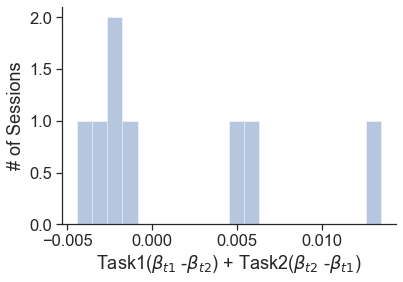

In [83]:
#n_sessions x n_tasks x n_params
all_beta = np.array(all_beta)

t1_m_t2_inT1 = (all_beta[:,0,-2] - all_beta[:,0,-1])
t1_m_t2_inT2 = (all_beta[:,1,-1] - all_beta[:,1,-2])

seaborn.distplot(t1_m_t2_inT1 + t1_m_t2_inT2,kde=0,bins=20)
plt.xlabel(r"Task1($\beta_{t1}$ -$\beta_{t2}$) + Task2($\beta_{t2}$ -$\beta_{t1}$)")
plt.ylabel("# of Sessions")
seaborn.despine()

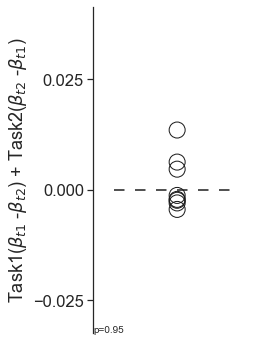

In [84]:
plt.figure(figsize=(3,6))
plt.scatter([0]*8,t1_m_t2_inT1 + t1_m_t2_inT2,s=256,facecolor='',edgecolor='k')
plt.annotate('p=0.95',(.0,0),xycoords='axes fraction')
plt.xticks([])
plt.plot([-.15,.15],[0,0],color='k',linestyle='--',dashes=(7,7))
plt.ylabel(r"Task1($\beta_{t1}$ -$\beta_{t2}$) + Task2($\beta_{t2}$ -$\beta_{t1}$)")
plt.xlim(-.2,.2)
plt.locator_params('y',nbins=3)
seaborn.despine(bottom=True)

In [95]:
np.array(all_pvals)[:,:,1].flatten()

array([9.16426877e-17, 7.95672416e-32, 1.39877942e-48, 9.82098233e-51,
       2.64359811e-32, 1.61316004e-29, 1.49510640e-20, 6.01844576e-27,
       3.08772033e-07, 1.30914812e-08, 4.54592193e-08, 7.27825521e-09,
       6.61417999e-47, 1.89516675e-30, 4.96445619e-40, 5.52951003e-37])

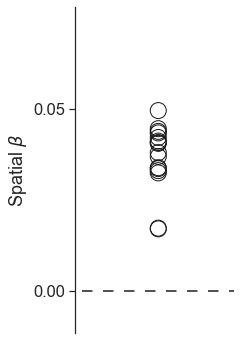

In [98]:
plt.figure(figsize=(3,6))
plt.scatter([0]*16,np.array(all_beta)[:,:,1].flatten(),s=256,facecolor='',edgecolor='k')
#plt.annotate('p=0.95',(.0,0),xycoords='axes fraction')
plt.xticks([])
plt.plot([-.15,.15],[0,0],color='k',linestyle='--',dashes=(7,7))
plt.ylabel(r"Spatial $\beta$")
#plt.xlim(-.2,.2)
plt.locator_params('y',nbins=3)
seaborn.despine(bottom=True)

In [2362]:
stt.ttest_1samp(t1_m_t2_inT1 + t1_m_t2_inT2,0)

Ttest_1sampResult(statistic=0.7445967465797968, pvalue=0.4807604377694731)

# Check this works by ordering according to sequence

In [1972]:
all_beta = []
all_pvals = []
for sess_ix in range(8):
    tmp  = []
    tmp_pvals = []
    firing_rate_maps,task_event_df,seq0,seq1,graph_type0,graph_type1, = load_data(sess_ix,by_dir=True)
    mxs = np.nanmax(firing_rate_maps,axis=(1,2,3))
    firing_rate_maps = firing_rate_maps[mxs>.1]
    #spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))
    mds_frm = firing_rate_maps #- spatial_map[:,:,None,None]

   
    
    frm = np.hstack([mds_frm[:,seq0,0,0],mds_frm[:,seq0,0,1],mds_frm[:,seq0,1,0],mds_frm[:,seq0,1,1]])
    frm_t1 = frm[:,:18].T
    frm_t2 = frm[:,18:].T
    #mean_state_resps = firing_rate_maps.swapaxes(0,2)
    #mean_state_resps = (mean_state_resps - np.mean(mean_state_resps,axis=(0,1))[None,None,:])/np.std(mean_state_resps,axis=(0,1))[None,None,:]
    #mean_state_resps = np.nan_to_num(mean_state_resps)
    #mean_state_resps = np.nanmean(mds_frm,axis=3).swapaxes(0,2)
    if graph_type0=='loop': 
        task_1_distance = get_C_loop_task(np.arange(9))[1]
    else: 
        task_1_distance =  get_C_line_task(np.arange(9))[1]
    if graph_type1=='loop':
        task_2_distance = get_C_loop_task(np.arange(9))[1]
    else:
        task_2_distance = get_C_line_task(np.arange(9))[1]

    task_1_distance = np.nan_to_num(task_1_distance,np.nanmean(task_1_distance))
    task_2_distance = np.nan_to_num(task_2_distance,np.nanmean(task_2_distance))
    #spatial_distance = -distance_matrix(poke_pos,poke_pos,p=1)
    spatial_distance =   -distance_matrix(np.vstack([poke_pos[seq0],poke_pos[seq0]]),
                                          np.vstack([poke_pos[seq0],poke_pos[seq0]]),p=1)
    
    task1_corrs = np.corrcoef(frm_t1)
    task2_corrs = np.corrcoef(frm_t2)
    select_indices = (np.eye(len(task1_corrs)) + 
                      np.isnan(task1_corrs) + 
                      np.isnan(task2_corrs) + 
                      np.isnan(task_1_distance) + 
                      np.isnan(task_2_distance) + 
                      np.isnan(spatial_distance)
                     )==0
    
    #
    y = task1_corrs[select_indices].flatten()
    X = np.vstack([np.ones_like(y),
               zscore(spatial_distance[select_indices].flatten()),
               zscore(task_1_distance[select_indices].flatten()),
               zscore(task_2_distance[select_indices].flatten())
              ]).T
    
    #y = remove_diagonal(task1_corrs).flatten()
    #beta = np.linalg.pinv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    
    tmp.append(res.params)
    tmp_pvals.append(res.pvalues)
    
    y = task2_corrs[select_indices].flatten()
    #beta = np.linalg.pinv(X.T@X)@X.T@y
    res = sm.OLS(y,X,hasconst=True).fit()
    
    tmp_pvals.append(res.pvalues)
    tmp.append(res.params)
    
    all_beta.append(tmp)
    all_pvals.append(tmp_pvals)
    #assert np.allclose(beta,res.params)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher

In [2057]:
#np.array(all_pvals)[:,:,3]

In [2058]:
#np.array(all_pvals)[:,:,1]

In [1965]:

distance_matrix.shape

AttributeError: 'function' object has no attribute 'shape'